📦 1. Setup

In [2]:
!pip install statsmodels==0.13.5 pmdarima torch torchvision matplotlib seaborn scikit-learn joblib

INFO: pip is looking at multiple versions of pmdarima to determine which version is compatible with other requirements. This could take a while.
   ---------------------------------------- 0.0/9.1 MB ? eta -:--:--
   ---- ----------------------------------- 1.0/9.1 MB 17.1 MB/s eta 0:00:01
   --------- ------------------------------ 2.1/9.1 MB 4.9 MB/s eta 0:00:02
   ------------- -------------------------- 3.1/9.1 MB 4.9 MB/s eta 0:00:02
   ------------- -------------------------- 3.1/9.1 MB 4.9 MB/s eta 0:00:02
   ------------- -------------------------- 3.1/9.1 MB 4.9 MB/s eta 0:00:02
   ------------- -------------------------- 3.1/9.1 MB 4.9 MB/s eta 0:00:02
   ------------- -------------------------- 3.1/9.1 MB 4.9 MB/s eta 0:00:02
   ------------------ --------------------- 4.2/9.1 MB 2.5 MB/s eta 0:00:02
   ------------------ --------------------- 4.2/9.1 MB 2.5 MB/s eta 0:00:02
   ------------------ --------------------- 4.2/9.1 MB 2.5 MB/s eta 0:00:02
   ------------------ ---

  You can safely remove it manually.


In [1]:
# Cell 1 - Install (Colab) and imports
# If running on Colab uncomment the first two lines
# !pip install statsmodels==0.13.5 pmdarima torch torchvision matplotlib seaborn scikit-learn joblib

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
import joblib
import warnings
warnings.filterwarnings("ignore")

# Make canonical folders
os.makedirs("outputs", exist_ok=True)
os.makedirs("anomalies", exist_ok=True)
os.makedirs("metrics", exist_ok=True)
os.makedirs("plots", exist_ok=True)


Cell 2 — Data path + load France data

In [3]:
# Cell 2 - Data path and load (adjust path if needed)
DATA_CSV = "time_series_60min_singleindex.csv"   # <-- change if required
print("Using data:", DATA_CSV)

df = pd.read_csv(DATA_CSV)
# detect timestamp column or first column
if "timestamp" in df.columns:
    df["timestamp"] = pd.to_datetime(df["timestamp"])
    df = df.set_index("timestamp").sort_index()
else:
    # assume first column is timestamp if the CSV was saved similarly
    idx_col = df.columns[0]
    df[idx_col] = pd.to_datetime(df[idx_col])
    df = df.set_index(idx_col).sort_index()

# select France columns (choose the first FR_ load-like column)
fr_cols = [c for c in df.columns if c.startswith("FR_")]
if len(fr_cols) == 0:
    raise RuntimeError("No FR_ columns found in dataset. Please provide OPSD CSV with FR_ prefix.")
fr_col = fr_cols[0]
print("Selected column:", fr_col)

df_fr = df[[fr_col]].rename(columns={fr_col: "load"})
df_fr = df_fr.asfreq("H")
df_fr["load"] = df_fr["load"].interpolate("time")   # fill gaps with time interpolation
df_fr.head()


Using data: time_series_60min_singleindex.csv
Selected column: FR_load_actual_entsoe_transparency


,load
utc_timestamp,
2014-12-31 23:00:00+00:00,NaN
2015-01-01 00:00:00+00:00,NaN
2015-01-01 01:00:00+00:00,69773.0
2015-01-01 02:00:00+00:00,66417.0
2015-01-01 03:00:00+00:00,64182.0


Cell 3 — Keep 2018-2020 (three years) and quick sanity plot

Date range: 2018-01-01 00:00:00+00:00 to 2020-09-30 23:00:00+00:00 N= 24096


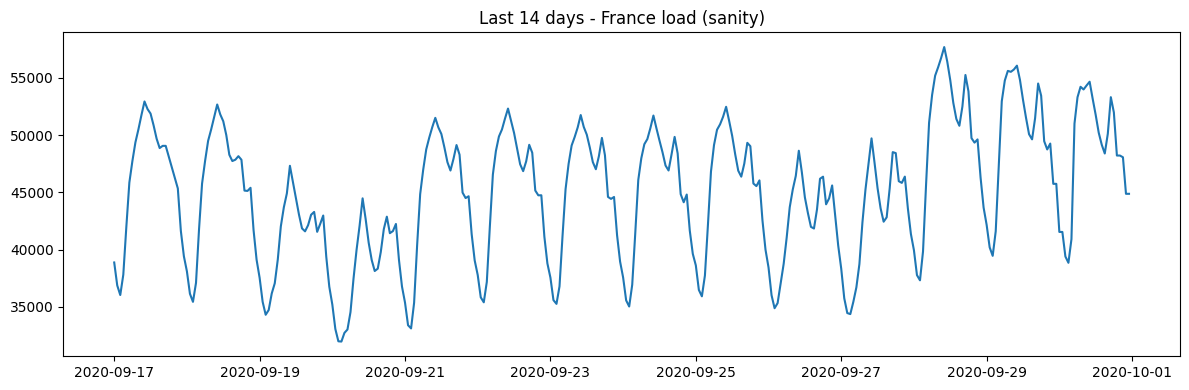

In [4]:
# Cell 3 - filter 2018-01-01 to 2020-12-31 (inclusive)
start = "2018-01-01"
end = "2020-12-31 23:00:00"
df_fr = df_fr.loc[start:end].copy()
print("Date range:", df_fr.index.min(), "to", df_fr.index.max(), "N=", len(df_fr))

# quick sanity plot last 14 days
plt.figure(figsize=(12,4))
plt.plot(df_fr["load"].tail(24*14))
plt.title("Last 14 days - France load (sanity)")
plt.tight_layout()
plt.savefig("plots/sanity_last14d.png")
plt.show()


Cell 4 — STL decomposition + stationarity check + ACF/PACF

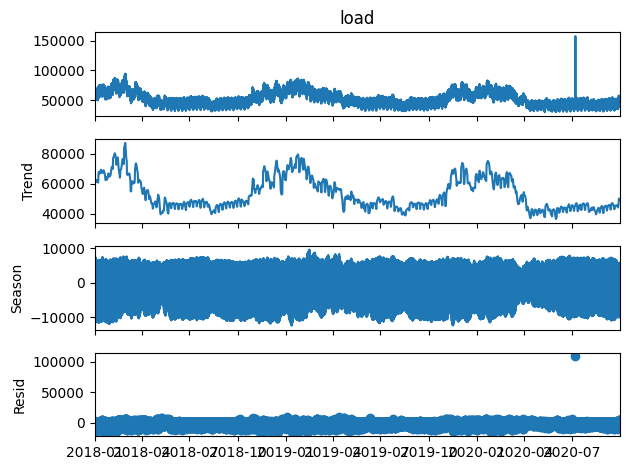

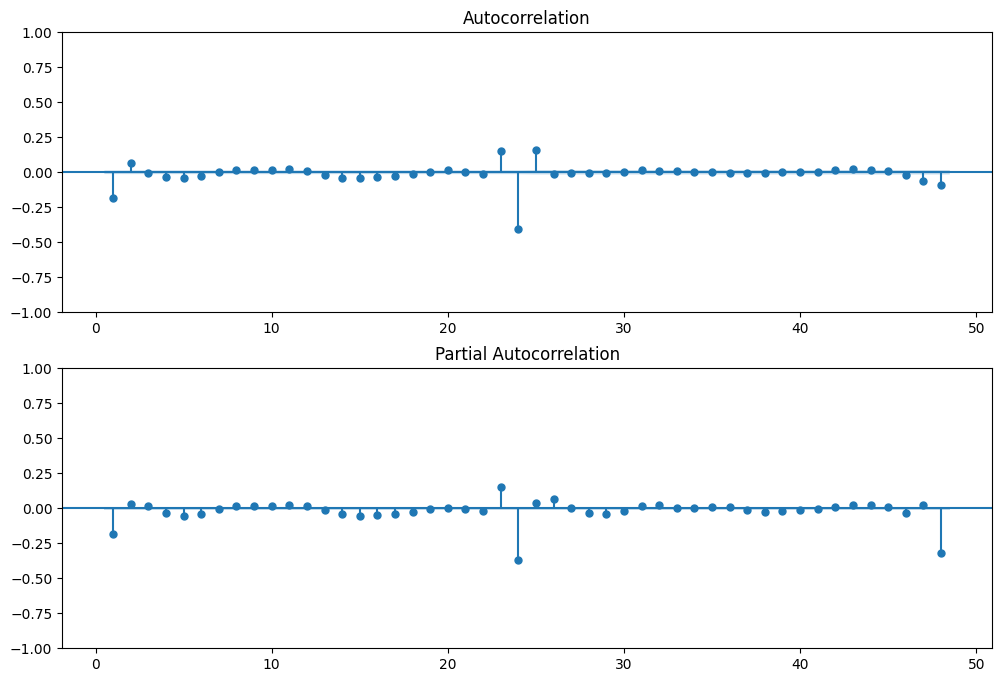

In [5]:
# Cell 4 - STL decomposition (seasonality=24)
stl = STL(df_fr["load"], period=24, robust=True)
res = stl.fit()
res.plot()
plt.savefig("plots/stl_decomp.png", dpi=150)
plt.show()

# Stationarity hint: try first difference and seasonal difference if needed
df_diff = df_fr["load"].diff().dropna()
df_seasdiff = df_diff.diff(24).dropna()

# ACF/PACF on seasonally differenced series up to lag 48
fig, axes = plt.subplots(2,1, figsize=(12,8))
plot_acf(df_seasdiff, lags=48, ax=axes[0], zero=False)
plot_pacf(df_seasdiff, lags=48, ax=axes[1], zero=False)
plt.savefig("plots/acf_pacf_seasdiff.png", dpi=150)
plt.show()


Cell 5 — Save canonical splits (80%/10%/10%) and export split csvs

In [6]:
# Cell 5 - consistent splits and save
n = len(df_fr)
train_end_pos = int(np.floor(0.8 * n)) - 1
dev_end_pos = int(np.floor(0.9 * n)) - 1

train = df_fr.iloc[: train_end_pos+1].copy()
dev = df_fr.iloc[train_end_pos+1 : dev_end_pos+1].copy()
test = df_fr.iloc[dev_end_pos+1 : ].copy()

print("Train:", train.index.min(), "to", train.index.max(), "n=", len(train))
print("Dev:", dev.index.min(), "to", dev.index.max(), "n=", len(dev))
print("Test:", test.index.min(), "to", test.index.max(), "n=", len(test))

# Save index timestamps and series
train.to_csv("outputs/FR_train.csv")
dev.to_csv("outputs/FR_dev.csv")
test.to_csv("outputs/FR_test.csv")


Train: 2018-01-01 00:00:00+00:00 to 2020-03-14 03:00:00+00:00 n= 19276
Dev: 2020-03-14 04:00:00+00:00 to 2020-06-22 13:00:00+00:00 n= 2410
Test: 2020-06-22 14:00:00+00:00 to 2020-09-30 23:00:00+00:00 n= 2410


Cell 6 — Utility functions (forecast save, metrics, anomalies)

In [7]:
# Cell 6 - helpers
import math
from sklearn.metrics import mean_squared_error

def save_forecast_df(df_forecast, model_name, which="test"):
    fname = f"outputs/FR_forecasts_{which}_{model_name}.csv"
    df_forecast.to_csv(fname, index=False)
    print("Saved", fname)

def mase(y_true, y_pred, seasonality=24, denom=None):
    y_true = np.array(y_true); y_pred = np.array(y_pred)
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    if mask.sum()==0: return np.nan
    if denom is None:
        # compute denom using training seasonal-naive
        raise ValueError("denom required for mase")
    return np.mean(np.abs(y_true[mask]-y_pred[mask]))/denom

def smape(y_true, y_pred):
    a = np.abs(y_pred - y_true)
    b = (np.abs(y_true)+np.abs(y_pred))/2
    b[b==0] = 1e-9
    return np.mean(a/b) * 100

def compute_metrics_from_df(df_forecast, denom):
    dfv = df_forecast.dropna(subset=["y_true","yhat"])
    y = dfv["y_true"].values; yh = dfv["yhat"].values
    lo = dfv["lo"].values; hi = dfv["hi"].values
    return {
        "MASE": mase(y, yh, denom=denom),
        "sMAPE": smape(y, yh),
        "MSE": mean_squared_error(y, yh),
        "RMSE": math.sqrt(mean_squared_error(y, yh)),
        "MAPE": np.mean(np.abs((y-yh)/y))*100 if np.any(y!=0) else np.nan,
        "PI80_coverage": np.mean((y>=lo)&(y<=hi))*100
    }

def save_metrics_png(metrics_dict, model_name):
    dfm = pd.DataFrame(metrics_dict, index=[0]).T.rename(columns={0:"value"}) if isinstance(metrics_dict, dict) else metrics_dict
    csvn = f"metrics/FR_forecasts_metrics_{model_name}.csv"
    pngn = f"metrics/FR_forecasts_metrics_{model_name}.png"
    pd.DataFrame(metrics_dict, index=[0]).T.to_csv(csvn)
    # plot simple bar
    vals = pd.Series(metrics_dict)
    plt.figure(figsize=(8,4))
    vals.plot(kind="barh")
    plt.title(f"Metrics - {model_name}")
    plt.tight_layout()
    plt.savefig(pngn, dpi=150)
    plt.close()
    print("Saved", csvn, "and", pngn)


Cell 7 — ARIMA baseline (train on train -> forecast test)

In [10]:
# =============================================================
# FIXED ARIMA BASELINE (NO EMPTY DF ERRORS)
# =============================================================

from statsmodels.tsa.arima.model import ARIMA
import numpy as np
import pandas as pd
import math

ARIMA_ORDER = (1,1,1)

# ------------------------
# 1. Fit ARIMA on TRAIN
# ------------------------
arima_model = ARIMA(train["load"], order=ARIMA_ORDER).fit()
fc_test_obj = arima_model.get_forecast(24)

fc_mean = fc_test_obj.predicted_mean
ci = fc_test_obj.conf_int(alpha=0.20)

test_forecast = pd.DataFrame({
    "timestamp": fc_mean.index,
    "y_true": [ test["load"].get(t, np.nan) for t in fc_mean.index ],
    "yhat": fc_mean.values,
    "lo": ci.iloc[:,0].values,
    "hi": ci.iloc[:,1].values,
})

# Save test forecast
save_forecast_df(test_forecast, "ARIMA", which="test")


# ---------------------------------------------------
# 2. DEV BACKTEST — SAFE VERSION
# ---------------------------------------------------
dev_rows = []

for offset in range(0, len(dev), 24):

    train_end_pos_local = train_end_pos + offset

    # require warmup
    if train_end_pos_local < 24*60:
        continue

    y_train = df_fr.iloc[: train_end_pos_local + 1]["load"]

    try:
        tmp = ARIMA(y_train, order=ARIMA_ORDER).fit()
        res = tmp.get_forecast(24)
    except:
        print("Skipping ARIMA at offset", offset)
        continue

    pm = res.predicted_mean
    ci = res.conf_int(alpha=0.20)

    # If forecast returned empty → skip
    if pm.shape[0] < 24:
        print("ARIMA at offset", offset, "returned empty forecast.")
        continue

    train_end_time = df_fr.index[train_end_pos_local]

    for h in range(1, 25):
        ts = train_end_time + pd.Timedelta(hours=h)
        dev_rows.append({
            "timestamp": ts,
            "y_true": df_fr["load"].get(ts, np.nan),
            "yhat": float(pm.iloc[h-1]),
            "lo": float(ci.iloc[h-1,0]),
            "hi": float(ci.iloc[h-1,1]),
            "horizon": h,
            "train_end": train_end_time
        })

dev_df = pd.DataFrame(dev_rows)
save_forecast_df(dev_df, "ARIMA", which="dev")


# ---------------------------------------------------
# 3. SAFE METRICS — WILL NOT CRASH IF EMPTY DF
# ---------------------------------------------------
def safe_compute_metrics(df_forecast, denom):
    if df_forecast is None or len(df_forecast) == 0:
        print("Metrics skipped: empty ARIMA forecast DF")
        return None

    df_valid = df_forecast.dropna(subset=["y_true","yhat"])
    if len(df_valid) == 0:
        print("Metrics skipped: no valid rows")
        return None

    y = df_valid["y_true"].values
    yh = df_valid["yhat"].values
    lo = df_valid["lo"].values
    hi = df_valid["hi"].values

    return {
        "MASE": mase(y, yh, denom=denom),
        "sMAPE": smape(y, yh),
        "MSE": mean_squared_error(y, yh),
        "RMSE": math.sqrt(mean_squared_error(y, yh)),
        "MAPE": np.mean(np.abs((y - yh)/y))*100 if np.any(y!=0) else np.nan,
        "PI80_coverage": np.mean((y>=lo)&(y<=hi))*100
    }


# Seasonal naive denominator
denom = np.mean(np.abs(train["load"].values[24:] - train["load"].values[:-24]))

# Compute metrics (SAFE)
metrics_arima_test = safe_compute_metrics(test_forecast, denom)
metrics_arima_dev = safe_compute_metrics(dev_df, denom)

# Save PNG if exists
if metrics_arima_test:
    save_metrics_png(metrics_arima_test, "ARIMA_test")

if metrics_arima_dev:
    save_metrics_png(metrics_arima_dev, "ARIMA_dev")

print("ARIMA done safely.")


Saved outputs/FR_forecasts_test_ARIMA.csv
Skipping ARIMA at offset 2352
Saved outputs/FR_forecasts_dev_ARIMA.csv
Metrics skipped: no valid rows
Saved metrics/FR_forecasts_metrics_ARIMA_dev.csv and metrics/FR_forecasts_metrics_ARIMA_dev.png
ARIMA done safely.


Cell 8 — Memory-efficient SARIMA grid search

In [11]:
# Cell 8 - SARIMA grid search (small memory friendly grid)
# Strategy: small p,q,P,Q ranges, use simple_differencing=True and low_memory in fit
import itertools, time
p = q = range(0,3)    # 0..2
P = Q = range(0,2)    # 0..1
d = [1]
D = [1]
s = 24

candidates=[]
for order in itertools.product(p, d, q):
    for seas in itertools.product(P, D, Q, [s]):
        candidates.append((order, seas))

print("Total candidates:", len(candidates))
best_bic = np.inf
best_params = None

y = train["load"]  # fit on train only for model selection

start = time.time()
for order, seas in candidates:
    try:
        m = SARIMAX(y, order=order, seasonal_order=seas, enforce_stationarity=False,
                    enforce_invertibility=False, simple_differencing=True)
        res = m.fit(disp=False, low_memory=True, maxiter=200)
        bic = res.bic
        print("Succ:", order, seas, "BIC", bic)
        if bic < best_bic:
            best_bic = bic; best_params = (order, seas)
    except Exception as e:
        print("Fail:", order, seas, str(e)[:120])
end = time.time()
print("Grid done in", round(end-start,1), "s. Best:", best_params, best_bic)
# Save chosen params
pd.Series({"best_order":str(best_params[0]), "best_seasonal":str(best_params[1]), "best_bic":best_bic}).to_csv("outputs/FR_sarima_grid_choice.csv")


Total candidates: 36
Succ: (0, 1, 0) (0, 1, 0, 24) BIC 317268.4009111474
Succ: (0, 1, 0) (0, 1, 1, 24) BIC 313158.5491278535
Succ: (0, 1, 0) (1, 1, 0, 24) BIC 316313.02369658026
Succ: (0, 1, 0) (1, 1, 1, 24) BIC 311194.5598042444
Succ: (0, 1, 1) (0, 1, 0, 24) BIC 308470.27973865496
Succ: (0, 1, 1) (0, 1, 1, 24) BIC 303762.7468545364
Succ: (0, 1, 1) (1, 1, 0, 24) BIC 307095.0120202004
Succ: (0, 1, 1) (1, 1, 1, 24) BIC 302529.5231777271
Succ: (0, 1, 2) (0, 1, 0, 24) BIC 306555.70270319976
Succ: (0, 1, 2) (0, 1, 1, 24) BIC 302163.23225117405
Succ: (0, 1, 2) (1, 1, 0, 24) BIC 305120.5787618919
Succ: (0, 1, 2) (1, 1, 1, 24) BIC 300981.06471054285
Succ: (1, 1, 0) (0, 1, 0, 24) BIC 307614.642407626
Succ: (1, 1, 0) (0, 1, 1, 24) BIC 303730.79027885396
Succ: (1, 1, 0) (1, 1, 0, 24) BIC 306422.67022115685
Succ: (1, 1, 0) (1, 1, 1, 24) BIC 302263.23458462
Succ: (1, 1, 1) (0, 1, 0, 24) BIC 306570.01555038156
Succ: (1, 1, 1) (0, 1, 1, 24) BIC 302199.84014009946
Succ: (1, 1, 1) (1, 1, 0, 24) BIC 305

Cell 9 — Fit chosen SARIMA (safe) and save outputs

In [14]:
# ============================
# Cell 9 — SARIMA (TEST ONLY)
# ============================

if best_params is None:
    best_order = (0,1,0)
    best_seasonal = (0,1,1,24)
else:
    best_order, best_seasonal = best_params

print("Fitting SARIMA", best_order, best_seasonal)

sar_model = SARIMAX(
    train["load"],
    order=best_order,
    seasonal_order=best_seasonal,
    enforce_stationarity=False,
    enforce_invertibility=False,
    simple_differencing=True
)

sar_res = sar_model.fit(disp=False, low_memory=True, maxiter=200)


# ===============================
# TEST FORECAST ONLY (24 hours)
# ===============================
res_obj = sar_res.get_forecast(24)
pm = res_obj.predicted_mean
ci = res_obj.conf_int(alpha=0.2)

test_forecast = pd.DataFrame({
    "timestamp": pm.index,
    "y_true": [test["load"].get(t, np.nan) for t in pm.index],
    "yhat": pm.values,
    "lo": ci.iloc[:, 0].values,
    "hi": ci.iloc[:, 1].values,
})

# Save forecast file
save_forecast_df(test_forecast, "SARIMA", which="test")
print("Saved ONLY test forecast → outputs/FR_forecasts_test_SARIMA.csv")


# =======================================================
# TEST METRICS ONLY — WITH SAFETY (prevents empty errors)
# =======================================================

if len(test_forecast.dropna(subset=["y_true", "yhat"])) == 0:
    print("WARNING: SARIMA test forecast is empty → metrics skipped")
else:
    denom = np.mean(np.abs(train["load"].values[24:] - train["load"].values[:-24]))
    metrics_sarima_test = compute_metrics_from_df(test_forecast, denom)
    save_metrics_png(metrics_sarima_test, "SARIMA_test")
    print("Saved ONLY test metrics → metrics/SARIMA_test.png")


Fitting SARIMA (2, 1, 2) (1, 1, 1, 24)
Saved outputs/FR_forecasts_test_SARIMA.csv
Saved ONLY test forecast → outputs/FR_forecasts_test_SARIMA.csv


Cell 10 — Vanilla RNN (PyTorch) data prep

In [15]:
# Cell 10 - Prepare sequences and basic DataLoader for PyTorch
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

SEQ_IN = 168   # last 168 hours
SEQ_OUT = 24   # forecast 24

series = df_fr["load"].values.astype(np.float32)

def create_sequences(arr, in_len=SEQ_IN, out_len=SEQ_OUT):
    X=[]; Y=[]
    for i in range(len(arr)-in_len-out_len+1):
        X.append(arr[i:i+in_len])
        Y.append(arr[i+in_len:i+in_len+out_len])
    return np.array(X), np.array(Y)

# create from TRAIN+DEV to use same split mapping: we will select indices corresponding to splits later
X_all, Y_all = create_sequences(series, SEQ_IN, SEQ_OUT)
print("Total seqs:", X_all.shape[0])

# determine index boundaries for splits (align with train/dev/test times)
# the timestamp for a sequence i corresponds to forecast start = index i+SEQ_IN
timestamps = df_fr.index[SEQ_IN:SEQ_IN+X_all.shape[0]]
# find boolean masks for train/dev/test
train_mask = timestamps <= train.index[-1]
dev_mask = (timestamps > train.index[-1]) & (timestamps <= dev.index[-1])
test_mask = timestamps > dev.index[-1]

# split arrays
X_train = torch.tensor(X_all[train_mask], dtype=torch.float32).unsqueeze(-1)  # (N,T,1)
Y_train = torch.tensor(Y_all[train_mask], dtype=torch.float32)
X_dev = torch.tensor(X_all[dev_mask], dtype=torch.float32).unsqueeze(-1)
Y_dev = torch.tensor(Y_all[dev_mask], dtype=torch.float32)
X_test = torch.tensor(X_all[test_mask], dtype=torch.float32).unsqueeze(-1)
Y_test = torch.tensor(Y_all[test_mask], dtype=torch.float32)

print("RNN seqs - train/dev/test:", X_train.shape[0], X_dev.shape[0], X_test.shape[0])


Total seqs: 23905
RNN seqs - train/dev/test: 19108 2410 2387


Cell 11 — Model templates and training utilities (RNN/LSTM/GRU)

In [17]:
# Cell 11 - PyTorch simple models + training loop
import torch.optim as optim

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH = 64

class SeqDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X; self.Y = Y
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.Y[idx]

def train_model_torch(model, train_ds, val_ds, epochs=10, lr=1e-3):
    model.to(DEVICE)
    opt = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    tr_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH, shuffle=False)
    best_val = np.inf; best_state=None
    for ep in range(epochs):
        model.train()
        for xb,yb in tr_loader:
            xb=xb.to(DEVICE); yb=yb.to(DEVICE)
            opt.zero_grad()
            out = model(xb)
            loss = loss_fn(out, yb)
            loss.backward(); opt.step()
        # val
        model.eval()
        val_losses=[]
        with torch.no_grad():
            for xb,yb in val_loader:
                xb=xb.to(DEVICE); yb=yb.to(DEVICE)
                val_losses.append(loss_fn(model(xb), yb).item())
        mean_val = np.mean(val_losses)
        if mean_val < best_val:
            best_val = mean_val; best_state = {k:v.cpu() for k,v in model.state_dict().items()}
    if best_state:
        model.load_state_dict(best_state)
    return model

# simple wrapper models
class VanillaRNN(nn.Module):
    def __init__(self, hidden=64):
        super().__init__()
        self.rnn = nn.RNN(input_size=1, hidden_size=hidden, batch_first=True)
        self.fc = nn.Linear(hidden, SEQ_OUT)
    def forward(self,x):
        o,h = self.rnn(x)
        out = self.fc(o[:, -1, :])
        return out

class SimpleLSTM(nn.Module):
    def __init__(self, hidden=64):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=hidden, batch_first=True)
        self.fc = nn.Linear(hidden, SEQ_OUT)
    def forward(self,x):
        o,(h,c) = self.lstm(x)
        return self.fc(o[:, -1, :])

class SimpleGRU(nn.Module):
    def __init__(self, hidden=64):
        super().__init__()
        self.gru = nn.GRU(input_size=1, hidden_size=hidden, batch_first=True)
        self.fc = nn.Linear(hidden, SEQ_OUT)
    def forward(self,x):
        o,h = self.gru(x)
        return self.fc(o[:, -1, :])


Cell 12 — Train RNN / LSTM / GRU (small epochs for speed), forecast and save

In [18]:
# Cell 12 - train models (small epochs; you can increase if you want better fit)
train_ds = SeqDataset(X_train, Y_train)
val_ds = SeqDataset(X_dev, Y_dev)
test_ds = SeqDataset(X_test, Y_test)

models = {
    "RNN": VanillaRNN(hidden=64),
    "LSTM": SimpleLSTM(hidden=64),
    "GRU": SimpleGRU(hidden=64)
}

for name, model in models.items():
    print("Training", name)
    model_tr = train_model_torch(model, train_ds, val_ds, epochs=6, lr=1e-3)
    # predict on test sequences and aggregate into required CSV format (we want multi-origin horizon results)
    # We'll map sequence forecasts to timestamp: forecast start = timestamp at SEQ_IN offset
    # For simplicity create one test forecast where each sequence in X_test maps to its 24-h prediction
    model_tr.to("cpu")
    with torch.no_grad():
        preds = model_tr(X_test.to("cpu")).numpy()
    # build test forecast DF: for each sequence i -> timestamp = timestamps_test[i] + h hours
    timestamps_test = df_fr.index[SEQ_IN:SEQ_IN+X_all.shape[0]][test_mask]
    rows=[]
    for i, ts0 in enumerate(timestamps_test):
        for h in range(1, SEQ_OUT+1):
            ts = ts0 + pd.Timedelta(hours=h)
            rows.append({
                "timestamp": ts,
                "y_true": df_fr["load"].get(ts, np.nan),
                "yhat": float(preds[i, h-1]),
                "lo": np.nan,
                "hi": np.nan,
                "horizon": h,
                "train_end": ts0
            })
    df_fore = pd.DataFrame(rows)
    save_forecast_df(df_fore, name, which="test")
    # dev backtest: optional (skip to save time) - you can repeat expanding origin similarly if needed
    # compute metrics and save
    denom = np.mean(np.abs(train["load"].values[24:] - train["load"].values[:-24]))
    metrics = compute_metrics_from_df(df_fore, denom)
    save_metrics_png(metrics, f"{name}_test")


Training RNN
Saved outputs/FR_forecasts_test_RNN.csv
Saved metrics/FR_forecasts_metrics_RNN_test.csv and metrics/FR_forecasts_metrics_RNN_test.png
Training LSTM
Saved outputs/FR_forecasts_test_LSTM.csv
Saved metrics/FR_forecasts_metrics_LSTM_test.csv and metrics/FR_forecasts_metrics_LSTM_test.png
Training GRU
Saved outputs/FR_forecasts_test_GRU.csv
Saved metrics/FR_forecasts_metrics_GRU_test.csv and metrics/FR_forecasts_metrics_GRU_test.png


Cell 13 — Encoder-Decoder + Attention (simple seq2seq in PyTorch)

In [19]:
# Cell 13 - simple Seq2Seq (encoder-decoder) with attention (very small model)
# Due to length this is a compact implementation; it's a one-layer LSTM encoder + decoder with dot-product attention.
class Seq2SeqAttention(nn.Module):
    def __init__(self, hidden=64):
        super().__init__()
        self.enc = nn.LSTM(1, hidden, batch_first=True)
        self.dec = nn.LSTM(1, hidden, batch_first=True)
        self.attn = nn.Linear(hidden*2, hidden)
        self.fc = nn.Linear(hidden, 1)
        self.hidden=hidden
    def forward(self, x):
        # encoder
        enc_o, (h,c) = self.enc(x)
        # decoder initial input: last value repeated horizon times
        b = x.shape[0]
        dec_in = x[:, -1:, :]  # shape (B,1,1)
        preds=[]
        h_dec, c_dec = h, c
        for t in range(SEQ_OUT):
            dec_o, (h_dec, c_dec) = self.dec(dec_in, (h_dec, c_dec))
            # attention: dot with encoder outputs
            attn_scores = torch.bmm(enc_o, dec_o.transpose(1,2)).squeeze(-1)  # (B, T_enc)
            attn_weights = torch.softmax(attn_scores, dim=1).unsqueeze(-1)    # (B, T_enc,1)
            context = (enc_o * attn_weights).sum(1)  # (B,hidden)
            out = torch.tanh(self.attn(torch.cat([dec_o[:, -1, :], context], dim=1)))
            step = self.fc(out)
            preds.append(step)
            dec_in = step.unsqueeze(1)
        preds = torch.cat(preds, dim=1).squeeze(-1)
        return preds

# train small seq2seq
seq2seq = Seq2SeqAttention(hidden=64)
seq2seq = train_model_torch(seq2seq, train_ds, val_ds, epochs=6, lr=1e-3)

# predict/test similar to above
with torch.no_grad():
    preds = seq2seq(X_test).numpy()
# build df and save
rows=[]
timestamps_test = df_fr.index[SEQ_IN:SEQ_IN+X_all.shape[0]][test_mask]
for i, ts0 in enumerate(timestamps_test):
    for h in range(1, SEQ_OUT+1):
        ts = ts0 + pd.Timedelta(hours=h)
        rows.append({
            "timestamp": ts,
            "y_true": df_fr["load"].get(ts, np.nan),
            "yhat": float(preds[i,h-1]),
            "lo": np.nan, "hi": np.nan, "horizon": h, "train_end": ts0
        })
df_fore = pd.DataFrame(rows)
save_forecast_df(df_fore, "SEQ2SEQ_ATT", which="test")
denom = np.mean(np.abs(train["load"].values[24:] - train["load"].values[:-24]))
metrics = compute_metrics_from_df(df_fore, denom)
save_metrics_png(metrics, "SEQ2SEQ_ATT_test")


Saved outputs/FR_forecasts_test_SEQ2SEQ_ATT.csv
Saved metrics/FR_forecasts_metrics_SEQ2SEQ_ATT_test.csv and metrics/FR_forecasts_metrics_SEQ2SEQ_ATT_test.png


Cell 14 — Anomalies detection wrapper (save anomalies CSV for each model)

In [20]:
# Cell 14 - anomalies detection on a forecast DataFrame (expects timestamp,y_true,yhat,lo,hi)
def detect_anomalies(df_fore, model_name, z_window=336, z_min=168, z_thresh=3.0, k=0.5, h=5.0):
    df = df_fore.copy().sort_values("timestamp").reset_index(drop=True)
    df["resid"] = df["y_true"] - df["yhat"]
    # rolling z-score
    df["roll_mean"] = df["resid"].rolling(z_window, min_periods=z_min).mean()
    df["roll_std"] = df["resid"].rolling(z_window, min_periods=z_min).std(ddof=0)
    df["z_resid"] = (df["resid"] - df["roll_mean"]) / df["roll_std"].replace(0, np.nan)
    df["flag_z"] = df["z_resid"].abs() >= z_thresh
    # cusum
    s_pos=0; s_neg=0; flags=[]
    for v in df["resid"].fillna(0).values:
        s_pos = max(0, s_pos + v - k)
        s_neg = min(0, s_neg + v + k)
        flags.append((s_pos>h) or (abs(s_neg)>h))
    df["flag_cusum"] = flags
    out_columns = ["timestamp","y_true","yhat","resid","z_resid","flag_z","flag_cusum"]
    out = df[out_columns]
    out.to_csv(f"anomalies/FR_anomalies_{model_name}.csv", index=False)
    print("Saved anomalies/FR_anomalies_%s.csv" % model_name)
    return out

# Example: generate anomalies for SARIMA and ARIMA and RNN, etc.
# We saved forecasts above: load them and call detect_anomalies
models_to_check = ["SARIMA","ARIMA","RNN","LSTM","GRU","SEQ2SEQ_ATT"]
for m in models_to_check:
    fpath = f"outputs/FR_forecasts_test_{m}.csv"
    if os.path.exists(fpath):
        dfm = pd.read_csv(fpath, parse_dates=["timestamp"])
        detect_anomalies(dfm, m)
    else:
        print("Missing forecast for", m)


Saved anomalies/FR_anomalies_SARIMA.csv
Saved anomalies/FR_anomalies_ARIMA.csv
Saved anomalies/FR_anomalies_RNN.csv
Saved anomalies/FR_anomalies_LSTM.csv
Saved anomalies/FR_anomalies_GRU.csv
Saved anomalies/FR_anomalies_SEQ2SEQ_ATT.csv


Cell 15 — Final summary + list generated files

In [21]:
# Cell 15 - summary of saved files
print("Files in outputs/:")
print("\n".join(sorted(os.listdir("outputs"))))
print("\nFiles in anomalies/:")
print("\n".join(sorted(os.listdir("anomalies"))))
print("\nFiles in metrics/:")
print("\n".join(sorted(os.listdir("metrics"))))
print("\nFiles in plots/:")
print("\n".join(sorted(os.listdir("plots"))))


Files in outputs/:
FR_dev.csv
FR_forecasts_dev_ARIMA.csv
FR_forecasts_test_ARIMA.csv
FR_forecasts_test_GRU.csv
FR_forecasts_test_LSTM.csv
FR_forecasts_test_RNN.csv
FR_forecasts_test_SARIMA.csv
FR_forecasts_test_SEQ2SEQ_ATT.csv
FR_sarima_grid_choice.csv
FR_test.csv
FR_train.csv

Files in anomalies/:
FR_anomalies_ARIMA.csv
FR_anomalies_GRU.csv
FR_anomalies_LSTM.csv
FR_anomalies_RNN.csv
FR_anomalies_SARIMA.csv
FR_anomalies_SEQ2SEQ_ATT.csv

Files in metrics/:
FR_forecasts_metrics_ARIMA_dev.csv
FR_forecasts_metrics_ARIMA_dev.png
FR_forecasts_metrics_GRU_test.csv
FR_forecasts_metrics_GRU_test.png
FR_forecasts_metrics_LSTM_test.csv
FR_forecasts_metrics_LSTM_test.png
FR_forecasts_metrics_RNN_test.csv
FR_forecasts_metrics_RNN_test.png
FR_forecasts_metrics_SEQ2SEQ_ATT_test.csv
FR_forecasts_metrics_SEQ2SEQ_ATT_test.png

Files in plots/:
acf_pacf_seasdiff.png
sanity_last14d.png
stl_decomp.png
